In [28]:
print("Hello World")

Hello World


In [29]:
import pandas as pd

corona_train_df = pd.read_csv('../data/ML-A2/Corona_train.csv')
corona_validation_df = pd.read_csv('../data/ML-A2/Corona_validation.csv')

corona_train_df.head()

,ID,Sentiment,CoronaTweet
0,22979,Positive,I see all kinds of academics already whipping ...
1,9880,Negative,@HenrySmithUK can you raise with Boris please ...
2,35761,Negative,It s a confusing odd time for the shopping pub...
3,37968,Positive,Blog Summary: The Impact of COVID-19 on the Ca...
4,19709,Neutral,??????? ??????? ???\r\r\nWaiting in a long Que...


In [30]:
train_sentiment_distribution = corona_train_df['Sentiment'].value_counts()

validation_head = corona_validation_df.head()

train_sentiment_distribution, validation_head

(Sentiment
 Positive    16602
 Negative    14166
 Neutral      7096
 Name: count, dtype: int64,
       ID Sentiment                                        CoronaTweet
 0   7184  Negative  I reflected on my own consumer behaviour last ...
 1  36363  Negative  I know everyone is getting stir crazy but befo...
 2  10423  Negative  I haven t seen gas prices this low since I fir...
 3   6409   Neutral  Only batmeat left on the supermarket shelves\r...
 4   7015   Neutral  Along with health workers, we need to apprecia...)

# Tokenization and building a vocabulary

In [31]:
from collections import Counter
import re

def preprocess_text(text):
    """Preprocess the text data by converting to lowercase, removing special characters and tokenizing."""
    text = text.lower()
    # text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
    tokens = text.split()
    return tokens

corona_train_df['Tokens'] = corona_train_df['CoronaTweet'].apply(preprocess_text)

all_tokens = [token for sublist in corona_train_df['Tokens'].tolist() for token in sublist]
vocabulary = Counter(all_tokens)

corona_train_df[['CoronaTweet', 'Tokens']].head(), vocabulary.most_common(10)


(                                         CoronaTweet  \
 0  I see all kinds of academics already whipping ...   
 1  @HenrySmithUK can you raise with Boris please ...   
 2  It s a confusing odd time for the shopping pub...   
 3  Blog Summary: The Impact of COVID-19 on the Ca...   
 4  ??????? ??????? ???\r\r\nWaiting in a long Que...   
 
                                               Tokens  
 0  [i, see, all, kinds, of, academics, already, w...  
 1  [@henrysmithuk, can, you, raise, with, boris, ...  
 2  [it, s, a, confusing, odd, time, for, the, sho...  
 3  [blog, summary:, the, impact, of, covid-19, on...  
 4  [???????, ???????, ???, waiting, in, a, long, ...  ,
 [('the', 40982),
  ('to', 35155),
  ('and', 21942),
  ('of', 19682),
  ('a', 17681),
  ('in', 17383),
  ('#coronavirus', 13746),
  ('for', 12887),
  ('is', 11168),
  ('are', 10349)])

# Naive Bayes Multiclass classification algorithm. Calculate the likelihoods of each token for each sentiment class, incorporating Laplace smoothing. Use logarithms to avoid underflow issues.

In [32]:
import numpy as np

classes = ['Positive', 'Negative', 'Neutral']
prior_probabilities = {}
word_given_class_probabilities = {}

for class_label in classes:
    prior_probabilities[class_label] = len(corona_train_df[corona_train_df['Sentiment'] == class_label]) / len(corona_train_df)

for class_label in classes:
    # Extract tokens for the current class
    tokens_in_class = [token for sublist in corona_train_df[corona_train_df['Sentiment'] == class_label]['Tokens'].tolist() for token in sublist]
    token_counts_in_class = Counter(tokens_in_class)
    
    # Calculate probabilities using Laplace smoothing
    word_given_class_probabilities[class_label] = {}
    for word in vocabulary:
        word_given_class_probabilities[class_label][word] = np.log((token_counts_in_class[word] + 1) / (len(tokens_in_class) + len(vocabulary)))

In [33]:
def naive_bayes_predict(tokens, prior_probabilities, word_given_class_probabilities):
    """Predict the class label using Naive Bayes."""
    class_scores = {}
    
    for class_label in prior_probabilities:
        class_scores[class_label] = np.log(prior_probabilities[class_label]) + \
                                    sum(word_given_class_probabilities[class_label].get(token, 0) for token in tokens)
    
    return max(class_scores, key=class_scores.get)

corona_train_df['PredictedSentiment'] = corona_train_df['Tokens'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))
corona_validation_df['Tokens'] = corona_validation_df['CoronaTweet'].apply(preprocess_text)
corona_validation_df['PredictedSentiment'] = corona_validation_df['Tokens'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))

train_accuracy = (corona_train_df['Sentiment'] == corona_train_df['PredictedSentiment']).mean()
validation_accuracy = (corona_validation_df['Sentiment'] == corona_validation_df['PredictedSentiment']).mean()

train_accuracy, validation_accuracy


(0.8438094231988168, 0.6774977224415427)

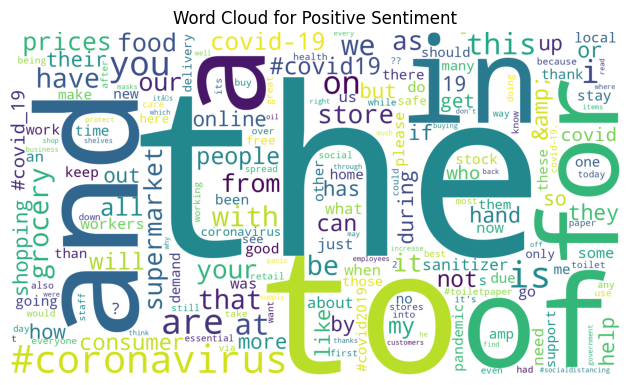

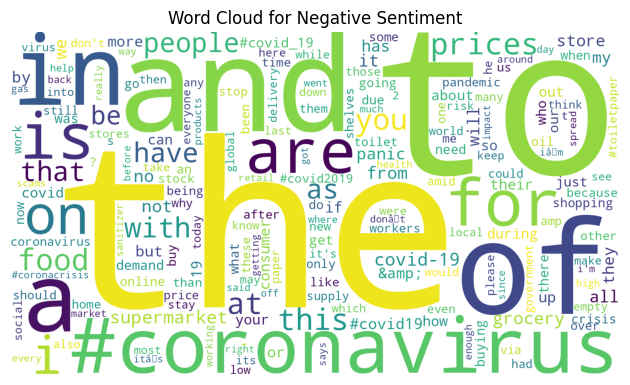

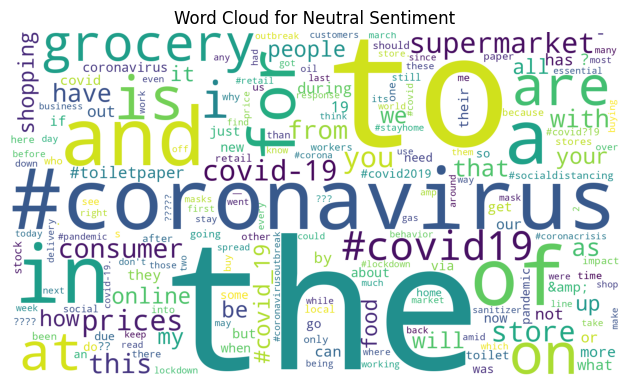

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for index, class_label in enumerate(classes, 1):
    tokens_in_class = [token for sublist in corona_train_df[corona_train_df['Sentiment'] == class_label]['Tokens'].tolist() for token in sublist]
    token_frequency_in_class = Counter(tokens_in_class)
    
    wordcloud = WordCloud(width=1600, height=900, background_color='white').generate_from_frequencies(token_frequency_in_class)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Word Cloud for {class_label} Sentiment')
    plt.tight_layout()
    plt.savefig(f'wordcloud_{class_label}.png')
    plt.show()


In [35]:
# Random Prediction
import random

def random_predict():
    """Predict the class label randomly."""
    return random.choice(classes)

corona_train_df['RandomlyPredictedSentiment'] = corona_train_df['Tokens'].apply(lambda x: random_predict())
corona_validation_df['RandomlyPredictedSentiment'] = corona_validation_df['Tokens'].apply(lambda x: random_predict())

random_train_accuracy = (corona_train_df['Sentiment'] == corona_train_df['RandomlyPredictedSentiment']).mean()
random_validation_accuracy = (corona_validation_df['Sentiment'] == corona_validation_df['RandomlyPredictedSentiment']).mean()

random_train_accuracy, random_validation_accuracy

(0.335041200084513, 0.3234133009413908)

In [36]:
# Always Predict Positive

def always_positive_predict():
    """Predict the class label as Positive."""
    return 'Positive'

corona_train_df['AlwaysPositivePredictedSentiment'] = corona_train_df['Tokens'].apply(lambda x: always_positive_predict())
corona_validation_df['AlwaysPositivePredictedSentiment'] = corona_validation_df['Tokens'].apply(lambda x: always_positive_predict())

always_positive_train_accuracy = (corona_train_df['Sentiment'] == corona_train_df['AlwaysPositivePredictedSentiment']).mean()
always_positive_validation_accuracy = (corona_validation_df['Sentiment'] == corona_validation_df['AlwaysPositivePredictedSentiment']).mean()

always_positive_train_accuracy, always_positive_validation_accuracy

(0.4384639763363617, 0.4385059216519891)

# Confusion Matrix

In [37]:
def create_confusion_matrix(actual_sentiments, predicted_sentiments):
    """Create a confusion matrix."""
    confusion_matrix = pd.DataFrame(index=classes, columns=classes)
    for actual_sentiment in classes:
        for predicted_sentiment in classes:
            confusion_matrix.loc[actual_sentiment, predicted_sentiment] = ((actual_sentiments == actual_sentiment) & (predicted_sentiments == predicted_sentiment)).sum()
    return confusion_matrix

# Create confusion matrix for training and validation datasets
train_confusion_matrix = create_confusion_matrix(corona_train_df['Sentiment'], corona_train_df['PredictedSentiment'])
validation_confusion_matrix = create_confusion_matrix(corona_validation_df['Sentiment'], corona_validation_df['PredictedSentiment'])

train_confusion_matrix, validation_confusion_matrix

(         Positive Negative Neutral
 Positive    15635      823     144
 Negative     1210    12821     135
 Neutral      2222     1380    3494,
          Positive Negative Neutral
 Positive     1215      209      20
 Negative      300      922      10
 Neutral       347      176      94)

In [38]:
random_train_confusion_matrix = create_confusion_matrix(corona_train_df['Sentiment'], corona_train_df['RandomlyPredictedSentiment'])
random_validation_confusion_matrix = create_confusion_matrix(corona_validation_df['Sentiment'], corona_validation_df['RandomlyPredictedSentiment'])

random_train_confusion_matrix, random_validation_confusion_matrix

(         Positive Negative Neutral
 Positive     5557     5473    5572
 Negative     4724     4734    4708
 Neutral      2375     2326    2395,
          Positive Negative Neutral
 Positive      467      484     493
 Negative      429      414     389
 Neutral       220      213     184)

In [39]:
always_positive_train_confusion_matrix = create_confusion_matrix(corona_train_df['Sentiment'], corona_train_df['AlwaysPositivePredictedSentiment'])
always_positive_validation_confusion_matrix = create_confusion_matrix(corona_validation_df['Sentiment'], corona_validation_df['AlwaysPositivePredictedSentiment'])

always_positive_train_confusion_matrix, always_positive_validation_confusion_matrix

(         Positive Negative Neutral
 Positive    16602        0       0
 Negative    14166        0       0
 Neutral      7096        0       0,
          Positive Negative Neutral
 Positive     1444        0       0
 Negative     1232        0       0
 Neutral       617        0       0)

# Removing stopwords and performing stemming

In [40]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def advanced_preprocess_text(tokens):
    """Remove stopwords and perform stemming on the tokens."""
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Perform stemming
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    return stemmed_tokens

corona_train_df['AdvancedTokens'] = corona_train_df['Tokens'].apply(advanced_preprocess_text)
corona_validation_df['AdvancedTokens'] = corona_validation_df['Tokens'].apply(advanced_preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hbot07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


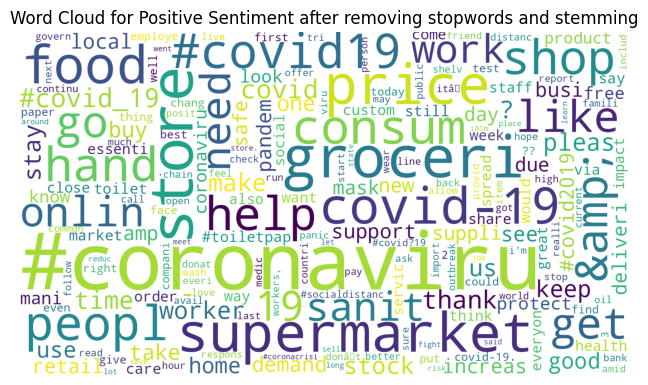

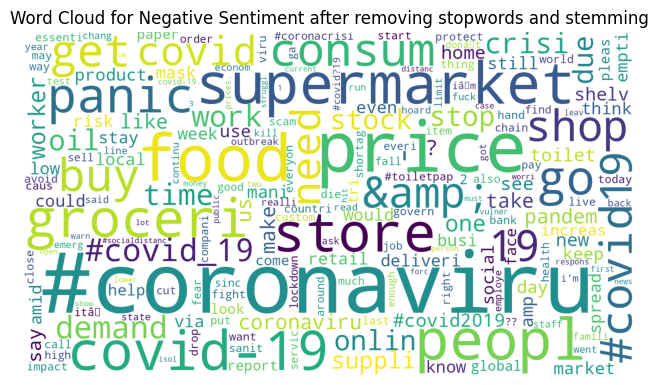

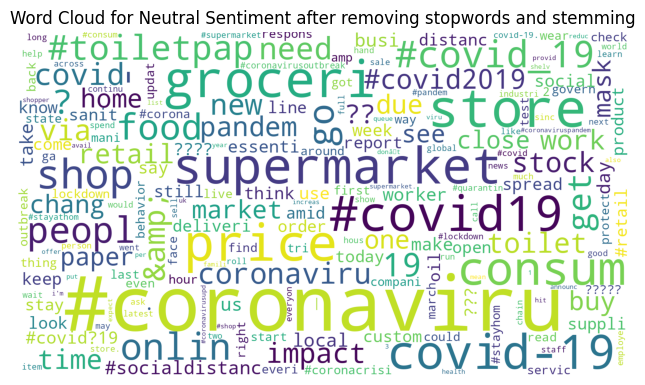

In [41]:
for index, class_label in enumerate(classes, 1):
    tokens_in_class = [token for sublist in corona_train_df[corona_train_df['Sentiment'] == class_label]['AdvancedTokens'].tolist() for token in sublist]
    token_frequency_in_class = Counter(tokens_in_class)
    
    # Create word cloud
    wordcloud = WordCloud(width=1600, height=900, background_color='white').generate_from_frequencies(token_frequency_in_class)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Word Cloud for {class_label} Sentiment after removing stopwords and stemming')
    plt.tight_layout()
    plt.savefig(f'wordcloud_{class_label}_stemming_and_removeStopwords.png')
    plt.show()

In [42]:
# Learn a new model on the transformed data and calculate accuracy on training and validation datasets.

prior_probabilities = {}
word_given_class_probabilities = {}

# Calculate prior probabilities for each class
for class_label in classes:
    prior_probabilities[class_label] = len(corona_train_df[corona_train_df['Sentiment'] == class_label]) / len(corona_train_df)

# Calculate word_given_class probabilities (with Laplace smoothing) for each class
for class_label in classes:
    # Extract tokens for the current class
    tokens_in_class = [token for sublist in corona_train_df[corona_train_df['Sentiment'] == class_label]['AdvancedTokens'].tolist() for token in sublist]
    token_counts_in_class = Counter(tokens_in_class)
    
    # Calculate probabilities using Laplace smoothing
    word_given_class_probabilities[class_label] = {}
    for word in vocabulary:
        word_given_class_probabilities[class_label][word] = np.log((token_counts_in_class[word] + 1) / (len(tokens_in_class) + len(vocabulary)))

prior_probabilities, {key: word_given_class_probabilities['Positive'][key] for key in list(word_given_class_probabilities['Positive'])[:5]}  # Displaying first 5 probabilities for 'Positive' class for brevity

({'Positive': 0.4384639763363617,
  'Negative': 0.37412845975068665,
  'Neutral': 0.1874075639129516},
 {'i': -13.032563388575666,
  'see': -6.446391733720991,
  'all': -13.032563388575666,
  'kinds': -13.032563388575666,
  'of': -13.032563388575666})

In [43]:
def naive_bayes_predict(tokens, prior_probabilities, word_given_class_probabilities):
    """Predict the class label using Naive Bayes."""
    class_scores = {}
    
    for class_label in prior_probabilities:
        class_scores[class_label] = np.log(prior_probabilities[class_label]) + \
                                    sum(word_given_class_probabilities[class_label].get(token, 0) for token in tokens)
    
    return max(class_scores, key=class_scores.get)

corona_train_df['PredictedSentiment'] = corona_train_df['AdvancedTokens'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))
corona_validation_df['PredictedSentiment'] = corona_validation_df['AdvancedTokens'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))

train_accuracy = (corona_train_df['Sentiment'] == corona_train_df['PredictedSentiment']).mean()
validation_accuracy = (corona_validation_df['Sentiment'] == corona_validation_df['PredictedSentiment']).mean()

train_accuracy, validation_accuracy

(0.8192742446651172, 0.6453082295778925)

# Bi-grams

In [44]:
def generate_bigrams(text):
    """Generate bi-grams from the text."""
    tokens = text
    bigrams = ["_".join(bigram) for bigram in zip(tokens[:-1], tokens[1:])]
    return bigrams + tokens

# Generating bi-grams for training and validation data
corona_train_df["Bigrams"] = corona_train_df["AdvancedTokens"].apply(generate_bigrams)
corona_validation_df["Bigrams"] = corona_validation_df["AdvancedTokens"].apply(generate_bigrams)

In [45]:
# Learn a new model on the transformed data and calculate accuracy on training and validation datasets.

prior_probabilities = {}
word_given_class_probabilities = {}

# Calculate prior probabilities for each class
for class_label in classes:
    prior_probabilities[class_label] = len(corona_train_df[corona_train_df['Sentiment'] == class_label]) / len(corona_train_df)

# Calculate word_given_class probabilities (with Laplace smoothing) for each class
for class_label in classes:
    # Extract tokens for the current class
    tokens_in_class = [token for sublist in corona_train_df[corona_train_df['Sentiment'] == class_label]['Bigrams'].tolist() for token in sublist]
    token_counts_in_class = Counter(tokens_in_class)
    
    # Calculate probabilities using Laplace smoothing
    word_given_class_probabilities[class_label] = {}
    for word in vocabulary:
        word_given_class_probabilities[class_label][word] = np.log((token_counts_in_class[word] + 1) / (len(tokens_in_class) + len(vocabulary)))

prior_probabilities, {key: word_given_class_probabilities['Positive'][key] for key in list(word_given_class_probabilities['Positive'])[:5]}  # Displaying first 5 probabilities for 'Positive' class for brevity
def naive_bayes_predict(tokens, prior_probabilities, word_given_class_probabilities):
    """Predict the class label using Naive Bayes."""
    class_scores = {}
    
    for class_label in prior_probabilities:
        class_scores[class_label] = np.log(prior_probabilities[class_label]) + \
                                    sum(word_given_class_probabilities[class_label].get(token, 0) for token in tokens)
    
    return max(class_scores, key=class_scores.get)

corona_train_df['PredictedSentiment'] = corona_train_df['Bigrams'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))
corona_validation_df['PredictedSentiment'] = corona_validation_df['Bigrams'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))

train_accuracy = (corona_train_df['Sentiment'] == corona_train_df['PredictedSentiment']).mean()
validation_accuracy = (corona_validation_df['Sentiment'] == corona_validation_df['PredictedSentiment']).mean()

train_accuracy, validation_accuracy

(0.8445225015846186, 0.6617066504706954)

In [46]:
def add_length(text):
    """Generate bi-grams from the text."""
    tokens = text
    bigrams = [len(text)]
    return bigrams + tokens

In [47]:
# Generating bi-grams for training and validation data
corona_train_df["with length"] = corona_train_df["Bigrams"].apply(generate_bigrams)
corona_validation_df["with length"] = corona_validation_df["Bigrams"].apply(generate_bigrams)

In [48]:
# Learn a new model on the transformed data and calculate accuracy on training and validation datasets.

prior_probabilities = {}
word_given_class_probabilities = {}

# Calculate prior probabilities for each class
for class_label in classes:
    prior_probabilities[class_label] = len(corona_train_df[corona_train_df['Sentiment'] == class_label]) / len(corona_train_df)

# Calculate word_given_class probabilities (with Laplace smoothing) for each class
for class_label in classes:
    # Extract tokens for the current class
    tokens_in_class = [token for sublist in corona_train_df[corona_train_df['Sentiment'] == class_label]['with length'].tolist() for token in sublist]
    token_counts_in_class = Counter(tokens_in_class)
    
    # Calculate probabilities using Laplace smoothing
    word_given_class_probabilities[class_label] = {}
    for word in vocabulary:
        word_given_class_probabilities[class_label][word] = np.log((token_counts_in_class[word] + 1) / (len(tokens_in_class) + len(vocabulary)))

prior_probabilities, {key: word_given_class_probabilities['Positive'][key] for key in list(word_given_class_probabilities['Positive'])[:5]}  # Displaying first 5 probabilities for 'Positive' class for brevity
def naive_bayes_predict(tokens, prior_probabilities, word_given_class_probabilities):
    """Predict the class label using Naive Bayes."""
    class_scores = {}
    
    for class_label in prior_probabilities:
        class_scores[class_label] = np.log(prior_probabilities[class_label]) + \
                                    sum(word_given_class_probabilities[class_label].get(token, 0) for token in tokens)
    
    return max(class_scores, key=class_scores.get)

corona_train_df['PredictedSentiment'] = corona_train_df['with length'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))
corona_validation_df['PredictedSentiment'] = corona_validation_df['with length'].apply(lambda x: naive_bayes_predict(x, prior_probabilities, word_given_class_probabilities))

train_accuracy = (corona_train_df['Sentiment'] == corona_train_df['PredictedSentiment']).mean()
validation_accuracy = (corona_validation_df['Sentiment'] == corona_validation_df['PredictedSentiment']).mean()

train_accuracy, validation_accuracy

(0.8350676103950982, 0.6632250227755846)

In [ ]:
# Domain Adaptation

